This Notebook is to be used to research and discover ways to identify Run/Pass tendencies using presnap data.
What this differs from the Down Breaks is that the model is using presnap data to aid in play calling decisions.
This Notebook will look into what players should be looking at after the play call in order to prepare themselves for either a run or passing situation.
Later on, I would like to look into adding in more specific play types like Play Action, Quick Pass, Inside Run, Outside Run, etc. to give more detail on what's to come.

First, let's look at a random forest model with the data we want to use.

The columns I want to use to predict Run/Pass are as follows:
Quarter
Down
Distance
Minutes Left
Personnel
Formation
Field Position
Hash
Formation Group (2x2, 1x3, etc.)
Yards gained on the previous play
Previous Play
Score Differential

Now that we have the variables we want to use, let's create an initial model to see what we find.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataframe = pd.read_csv("datasets/purdue_2022.csv")
dataframe.head()

,Playid,Gameid,Gamedate,Gameseason,Week,Gsisgamekey,Gsisplayid,Quarter,Down,Clock,...,Unblockedpressure,Vise,Wralignment1,Wralignment2,Wralignment3,Wralignment4,Unnamed: 180,Contested,Runpassoption,Playclock
0,4453436,21589,9/1/2022,2022,1,82512,37,1,0,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,4453598,21589,9/1/2022,2022,1,82512,148,1,1,14:03,...,PAST D46 (R.A.S) LOLB,NaN,-14.5,-5.5,10.5,18.5,NaN,NaN,0,16.0
2,4453616,21589,9/1/2022,2022,1,82512,172,1,2,13:33,...,NaN,NaN,-16.5,-11.5,-6.5,16.5,NaN,NaN,1,19.0
3,4453648,21589,9/1/2022,2022,1,82512,196,1,1,13:06,...,NaN,NaN,-10.5,3.5,17.5,NaN,NaN,NaN,1,15.0
4,4453663,21589,9/1/2022,2022,1,82512,218,1,2,12:30,...,NaN,NaN,-1.5,3.5,13.5,NaN,NaN,1; PAST D09,0,10.0


In [2]:
dataframe['Gainloss'] = dataframe['Gainloss'].replace(" ", np.nan, regex=True)

dataframe['Yards on Previous Play'] = dataframe['Gainloss'].shift() #created a new column that moved the yards gained or lost on a play down a row
dataframe['Yards on Previous Play'].fillna(0, inplace = True) #any NA values were filled with a 0

dataframe["previous_play"] = dataframe["Runpass"].shift()

dataframe = dataframe[(dataframe["Runpass"] == "R") | (dataframe["Runpass"] == "P")]
dataframe = dataframe[(dataframe["previous_play"] == "R") | (dataframe["previous_play"] == "P")]

#extra data cleaning pieces to make downs be 1-4, runpass to only be R or P, and offensive personnel to be known and have 11 players on the field
dataframe = dataframe[(dataframe['Offpersonnelbasic'] != 'Unknown') & (dataframe['Offpersonnelbasic'] != '10 Men') & (dataframe['Passdirection'] != 'X')]

#created a subset with the features that can be seen presnap to do ML on
subset = dataframe[['Quarter','Minutes Left', 'Down','Distance','Fieldposition','Offpersonnelbasic','Runpass','Yards on Previous Play','Scoredifferential', 'previous_play', 'Offformationgroup', 'Hash']]
subset = subset.dropna(subset = ['Quarter','Minutes Left','Down','Distance','Fieldposition','Offpersonnelbasic','Runpass','Scoredifferential', 'Yards on Previous Play', 'previous_play', 'Offformationgroup', 'Hash'])
subset.head()

,Quarter,Minutes Left,Down,Distance,Fieldposition,Offpersonnelbasic,Runpass,Yards on Previous Play,Scoredifferential,previous_play,Offformationgroup,Hash
2,1,13.55,2,2,-39,11,P,8.0,0,P,3x1,C
3,1,13.10,1,10,-49,10 (*),R,10.0,0,P,2x2,R
4,1,12.50,2,9,50,10 (*),P,1.0,0,R,2x2,R
5,1,11.87,1,10,40,11,P,10.0,0,P,2x2,L
6,1,11.80,2,10,40,11,P,0.0,0,P,1x3,L


In [3]:

cleaned_data = subset.astype({'Yards on Previous Play' : 'int'})

cleaned_data_w_dummies = pd.get_dummies(cleaned_data, columns=['Offpersonnelbasic', "previous_play", "Offformationgroup", "Hash"])

predictors = cleaned_data_w_dummies.columns.drop(['Runpass']) #predictor variables used: all variables besides the target variable
target = cleaned_data_w_dummies['Runpass'].values #target variable

#splits the subset into a training set to fit the models on and a testing set to test the models on for their accuracy
train_data, test_data, train_sln, test_sln = train_test_split(cleaned_data_w_dummies[predictors].values, target, test_size = 0.2, random_state=0)
cleaned_data_w_dummies.head()

,Quarter,Minutes Left,Down,Distance,Fieldposition,Runpass,Yards on Previous Play,Scoredifferential,Offpersonnelbasic_0,Offpersonnelbasic_1,...,Offformationgroup_2x2,Offformationgroup_2x3,Offformationgroup_3x0,Offformationgroup_3x1,Offformationgroup_3x2,Offformationgroup_4x0,Offformationgroup_4x1,Hash_C,Hash_L,Hash_R
2,1,13.55,2,2,-39,P,8,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1,13.10,1,10,-49,R,10,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,1,12.50,2,9,50,P,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5,1,11.87,1,10,40,P,10,0,0,0,...,1,0,0,0,0,0,0,0,1,0
6,1,11.80,2,10,40,P,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


With all the dummy variables created with the personnel packages, it can get to be a bit noisy with all the new columns created from it. So, let's try splitting the personnel packages into 3 groups: Run Heavy, Neutral, and Pass Heavy. Run Heavy will include all 20+ and 13 personnel packages. Neautral will include 12, 11, and 10. and Pass Heavy will include 02, 01, 00 packages respectively. Let's try it out and see if it will improve the model at all.

In [49]:
run_heavy = ["22 (*)", "22", "20", "21", "21 (*)", "13", "13 (*)", "20 (*)", "31 (*)", "23"]
neutral = ["10", "11", "11 (*)", "10 (*)", "11 (**)", "12", "12 (*)", "12 (**)", "10 (**)"]
pass_heavy = ["1", "2", "0"]

conditions = [subset["Offpersonnelbasic"].isin(run_heavy), subset["Offpersonnelbasic"].isin(pass_heavy), subset["Offpersonnelbasic"].isin(neutral)]
choices = ["Run Heavy", "Pass Heavy", "Neutral"]

subset["personnel_categories"] = np.select(conditions, choices)

cleaned_data = subset.astype({'Yards on Previous Play' : 'int', 'personnel_categories' : 'str'})

subset["personnel_categories"] = subset["personnel_categories"].astype("category")
subset["Offformationgroup"] = subset["Offformationgroup"].astype("category")
subset["Hash"] = subset["Hash"].astype("category")
subset["Runpass"] = subset["Runpass"].astype("category")
subset["previous_play"] = subset["previous_play"].astype("category")
subset["Offpersonnelbasic"] = subset["Offpersonnelbasic"].astype("category")

cleaned_data_w_dummies = pd.get_dummies(cleaned_data, columns=['personnel_categories', "previous_play", "Offformationgroup", "Hash"])

predictors = cleaned_data_w_dummies.columns.drop(['Runpass', 'Offpersonnelbasic']) #predictor variables used: all variables besides the target variable
target = cleaned_data_w_dummies['Runpass'].values #target variable

#splits the subset into a training set to fit the models on and a testing set to test the models on for their accuracy
train_data, test_data, train_sln, test_sln = train_test_split(cleaned_data_w_dummies[predictors].values, target, test_size = 0.20, random_state=0)
cleaned_data_w_dummies.head()

,Quarter,Minutes Left,Down,Distance,Fieldposition,Offpersonnelbasic,Runpass,Yards on Previous Play,Scoredifferential,personnel_categories_Neutral,...,Offformationgroup_2x2,Offformationgroup_2x3,Offformationgroup_3x0,Offformationgroup_3x1,Offformationgroup_3x2,Offformationgroup_4x0,Offformationgroup_4x1,Hash_C,Hash_L,Hash_R
2,1,13.55,2,2,-39,11,P,8,0,1,...,0,0,0,1,0,0,0,1,0,0
3,1,13.10,1,10,-49,10 (*),R,10,0,1,...,1,0,0,0,0,0,0,0,0,1
4,1,12.50,2,9,50,10 (*),P,1,0,1,...,1,0,0,0,0,0,0,0,0,1
5,1,11.87,1,10,40,11,P,10,0,1,...,1,0,0,0,0,0,0,0,1,0
6,1,11.80,2,10,40,11,P,0,0,1,...,0,0,0,0,0,0,0,0,1,0


0.735632183908046
11


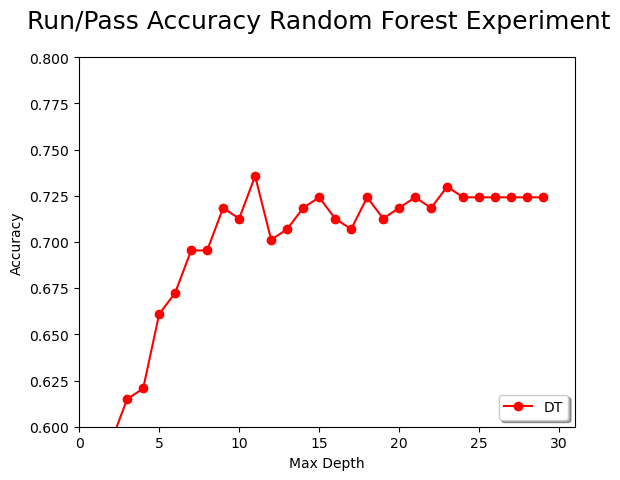

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

d = range(1,30)

results = []

for i in d:
  dt = RandomForestClassifier(max_depth= i, random_state = 0) #finding the maximum depth for the decision trees to go to
  dt.fit(train_data,train_sln)
  prediction = dt.predict(test_data)
  val = accuracy_score(test_sln,prediction)
  results.append(val)

#Graphing code
plt.suptitle('Run/Pass Accuracy Random Forest Experiment',fontsize=18)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(d,results,'ro-',label='DT')
plt.legend(loc='lower right', shadow=True)
plt.axis([0,31,0.60,0.80])

print(max(results))
print(d[results.index(max(results))])
plt.show()

0.7528735632183908
150


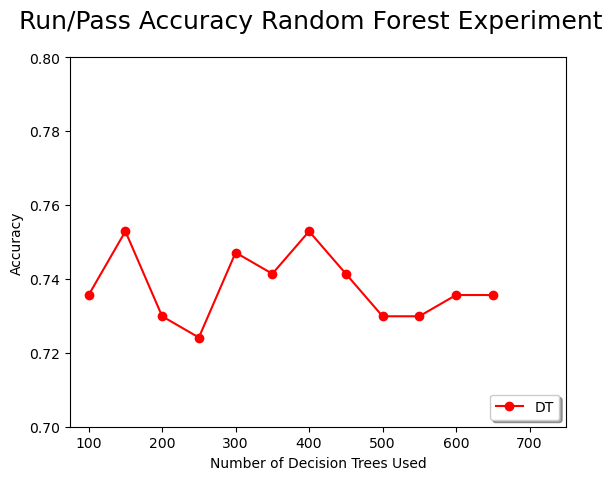

In [57]:
d = range(100,700,50)

results = []

for i in d:
  dt = RandomForestClassifier(max_depth= 11, random_state= 0, n_estimators=i)
  dt.fit(train_data,train_sln)
  prediction = dt.predict(test_data)
  val = accuracy_score(test_sln,prediction)
  results.append(val)

plt.suptitle('Run/Pass Accuracy Random Forest Experiment',fontsize=18)
plt.xlabel('Number of Decision Trees Used')
plt.ylabel('Accuracy')
plt.plot(d,results,'ro-',label='DT')
plt.legend(loc='lower right', shadow=True)
plt.axis([75,750,0.70,0.80])

print(max(results))
print(d[results.index(max(results))])
plt.show()

0.7528735632183908
2


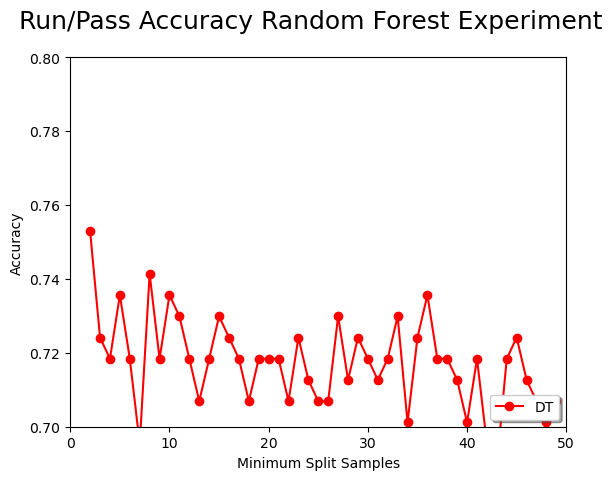

In [52]:
d = range(2,50)

results = []

for i in d:
  dt = RandomForestClassifier(max_depth= 11, random_state= 0, n_estimators=150, min_samples_split=i)
  dt.fit(train_data,train_sln)
  prediction = dt.predict(test_data)
  val = accuracy_score(test_sln,prediction)
  results.append(val)

plt.suptitle('Run/Pass Accuracy Random Forest Experiment',fontsize=18)
plt.xlabel('Minimum Split Samples')
plt.ylabel('Accuracy')
plt.plot(d,results,'ro-',label='DT')
plt.legend(loc='lower right', shadow=True)
plt.axis([0,50,0.70,0.80])

print(max(results))
print(d[results.index(max(results))])
plt.show()

0.7528735632183908
1


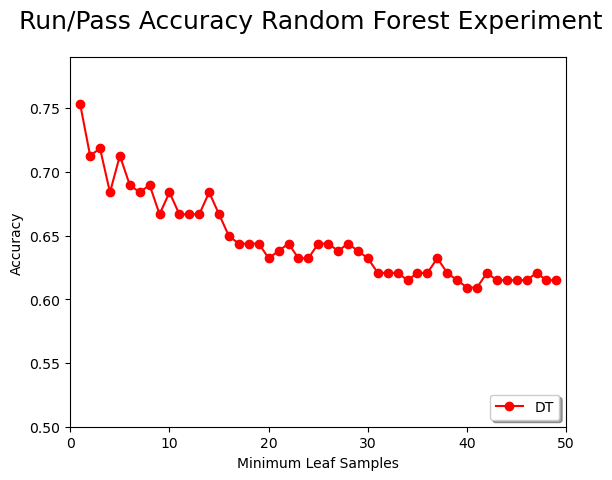

In [53]:
d = range(1,50)

results = []

for i in d:
  dt = RandomForestClassifier(max_depth= 11, random_state= 0, n_estimators= 150, min_samples_split=2, min_samples_leaf= i)
  dt.fit(train_data,train_sln)
  prediction = dt.predict(test_data)
  val = accuracy_score(test_sln,prediction)
  results.append(val)

plt.suptitle('Run/Pass Accuracy Random Forest Experiment',fontsize=18)
plt.xlabel('Minimum Leaf Samples')
plt.ylabel('Accuracy')
plt.plot(d,results,'ro-',label='DT')
plt.legend(loc='lower right', shadow=True)
plt.axis([0,50,0.50,0.79])

print(max(results))
print(d[results.index(max(results))])
plt.show()

0.7758620689655172
20


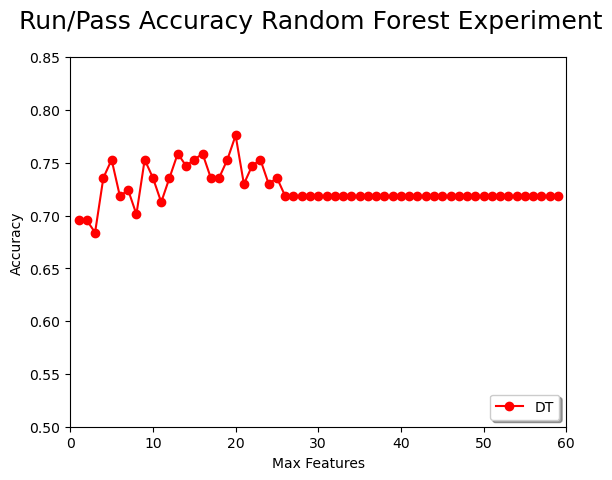

In [54]:
d = range(1,60)

results = []

for i in d:
  dt = RandomForestClassifier(max_depth= 11, random_state= 0, n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features= i)
  dt.fit(train_data,train_sln)
  prediction = dt.predict(test_data)
  val = accuracy_score(test_sln,prediction)
  results.append(val)

plt.suptitle('Run/Pass Accuracy Random Forest Experiment',fontsize=18)
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.plot(d,results,'ro-',label='DT')
plt.legend(loc='lower right', shadow=True)
plt.axis([0,60,0.50,0.85])

print(max(results))
print(d[results.index(max(results))])
plt.show()

Accuracy: 0.7758620689655172
___________________________________________________________


Text(0.5, 0, 'Predicted label')

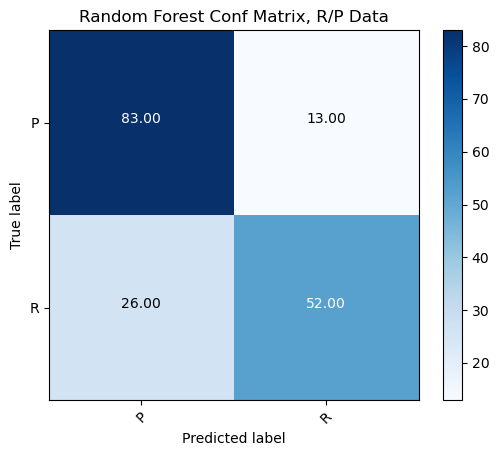

In [55]:
from sklearn import metrics

dt = RandomForestClassifier(max_depth= 11, random_state= 0, n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features= 20)
dt.fit(train_data,train_sln)
prediction = dt.predict(test_data)
val = accuracy_score(test_sln,prediction)

print('Accuracy:', val)

print('___________________________________________________________')

import itertools

cm=metrics.confusion_matrix(test_sln,prediction)
plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
plt.title('Random Forest Conf Matrix, R/P Data')
plt.colorbar()
plt.xticks([0,1], dt.classes_,rotation=45)
plt.yticks([0,1], dt.classes_)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')

accuracy score:  0.7758620689655172


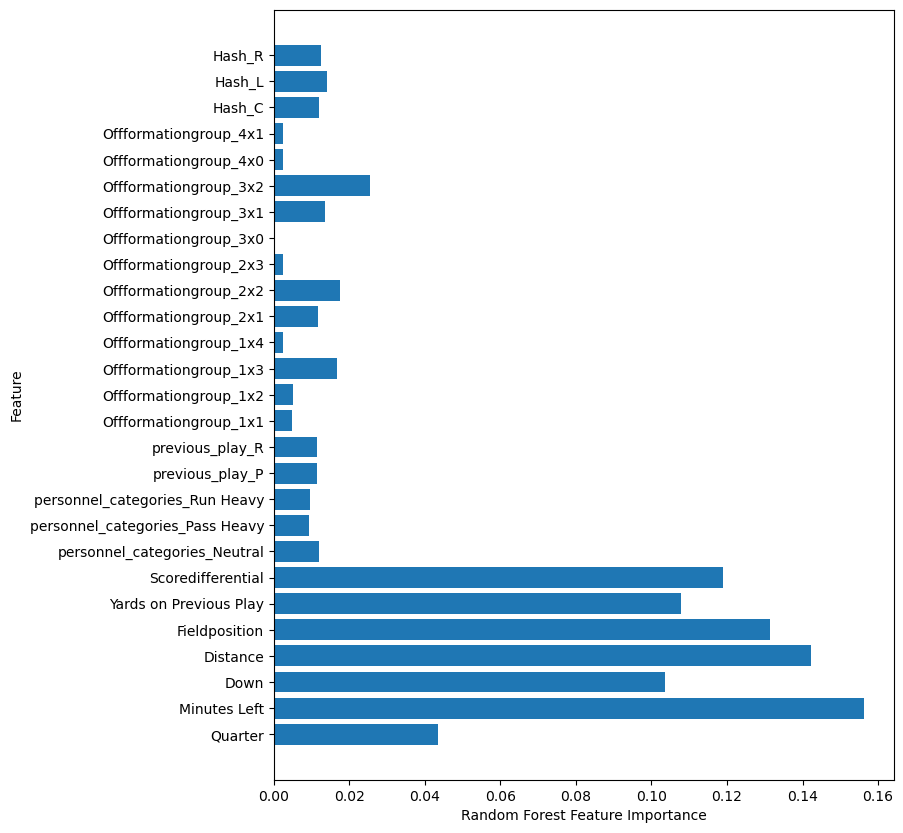

In [56]:
#Find feature significance for this dataset
forest = RandomForestClassifier(max_depth= 11, random_state= 0, n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features= 20)
forest.fit(train_data,train_sln)
predictions = forest.predict(test_data)
print("accuracy score: ", accuracy_score(test_sln,predictions))


%matplotlib inline

index = range(len(predictors)) #creates a list of numbers the right size to use as the index

plt.figure(figsize=(8,10)) #making the table a bit bigger so the text is readable
plt.barh(index,forest.feature_importances_,height=0.8) #horizontal bar chart
plt.ylabel('Feature')
plt.yticks(index,predictors) #put the feature names at the y tick marks
plt.xlabel("Random Forest Feature Importance")
plt.show()

We gained some improvements from combining the personnel packages into categories which definitely helped! If we are giving this data to players specifically, then it would be useful for the players to identify that they are in certain personnel category instead of having to remember each specific personnel package.